In [77]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn import *
from scipy.interpolate import interp1d

# =================================
#             Functions
# =================================
def splitDate(arr):
    dateColumn = arr['Date'].str.split('-')
    arr['Year'] = pd.to_numeric(dateColumn.str[-3]);
    arr['Month'] = pd.to_numeric(dateColumn.str[-2]);
    arr['Week'] = pd.to_numeric(dateColumn.str[-1]) / 2;
    arr['DayFromBeginnig'] = pd.to_numeric(dateColumn.str[-2]) * 25 + pd.to_numeric(dateColumn.str[-1]);
    arr['combination2'] = arr['DayFromBeginnig'] / arr['Month'];
    arr['combination3'] = arr['Month'] / arr['Year'];
    arr['combination4'] = arr['DayFromBeginnig'] / arr['combination3'];
    return arr

def convertWeatherType(weather):
    weather['TS'] = pd.Series(0, index=weather.index)
    weather['FG'] = pd.Series(0, index=weather.index)
    i = 0
    for weatherElt in weather.values:
        if ('TS' in weatherElt[12]):
            weather.loc[i, 'TS'] = 1
        else:
            weather.loc[i, 'TS'] = 0
        
        if ('FG' in weatherElt[12]):
            weather.loc[i, 'FG'] = 1
        else:
            weather.loc[i, 'FG'] = 0
        i = i + 1
    return weather

def addTemperatureDiff(weather):
    weather['Tdiff_min'] = pd.Series(0, index=weather.index)
    weather['Tdiff_max'] = pd.Series(0, index=weather.index)
    weather['Tavg'].replace('M', np.nan, inplace = True);
    weather['Tavg'] = pd.to_numeric(weather['Tavg'])
    i = 0
    for weatherElt in weather.values:
        weather.loc[i, 'Tdiff'] = weatherElt[4] - weatherElt[3]
        i = i + 1
    return weather

def join_features_spray(data):
    data['SprayExist'] = pd.Series(0, index=train.index)
    i = 0
    for trainElt in data.values:
        curTrainMonth = datetime.datetime.strptime(trainElt[0], "%Y-%m-%d").month
        curTrainDay = datetime.datetime.strptime(trainElt[0], "%Y-%m-%d").day        
        if (curTrainMonth == 7 or curTrainMonth == 8 or curTrainMonth == 9) and curTrainDay > 10 and curTrainDay < 26:
            data.loc[i, 'SprayExist'] = 1
        i = i + 1
    return data

def speciesToNums(arr):
    arr['Species'] = arr['Species'].map({'UNSPECIFIED CULEX': -1, 'CULEX ERRATICUS':0, 'CULEX SALINARIUS':1, 'CULEX TARSALIS':2, 'CULEX TERRITANS':3, 'CULEX RESTUANS':4, 'CULEX PIPIENS/RESTUANS':5, 'CULEX PIPIENS':6})
    return arr

# important: call begore deleting 'WnvPresent' from train
def makeTrapsOrder(arr):
    trapWnvPresent = arr.groupby('Trap')['WnvPresent'].mean()
    trapWnvPresent.sort_values(inplace=True)

    # smart ordinals
    i = 0
    while i < len(trapWnvPresent) and trapWnvPresent[i] == 0:
        trapWnvPresent[i] = 0
        i += 1
    start_num = i;
    while i < len(trapWnvPresent):
        trapWnvPresent[i] = i - start_num + 1;
        i += 1
    return trapWnvPresent;

def trapsToNums(trapsOrder, arr):
    def trap_process(x):
        if x in trapsOrder.index:
            return trapsOrder[x];
        else:
            return 0; # maybe not 0 when there is no information about trap (?)
    arr['Trap'] = arr['Trap'].map(lambda x: trap_process(x)) 
    return arr
    

def join_features_weather(train, weather):
    if (train.index.name != 'Date'):
        train = train.set_index('Date')
    joined = train.join(weather.set_index('Date'), rsuffix = 'r')
    return joined


def weather_processing():
    weather = pd.read_csv('weather.csv')
    weather = convertWeatherType(weather)
    weather = addTemperatureDiff(weather)
    weather['Heat'].replace('M', np.nan, inplace = True);
    weather['Heat'] = pd.to_numeric(weather['Heat'])
    weather['WetBulb'].replace('M', np.nan, inplace = True);
    weather['WetBulb'] = pd.to_numeric(weather['WetBulb'])
    return weather

# divide weather into two dataframes - station1 and station2
# join them to train on date
def join_arr_weather(weather, train):
    # do partition into 2 dataframes
    weatherSt1 = weather.drop(weather[weather.Station == 2].index)
    weatherSt1 = weatherSt1.add_suffix('_St1')
    
    weatherSt2 = weather.drop(weather[weather.Station == 1].index)
    weatherSt2 = weatherSt2.add_suffix('_St2')
    # only several columns required 
    weatherNamesArray_St1 = ['Tdiff_St1', 'Tavg_St1', 'Tmin_St1', 'DewPoint_St1']
    weatherNamesArray_St2 = ['DewPoint_St2', 'Tavg_St2', 'Tmin_St2']
    
    weatherSt1.rename(columns={'Date_St1':'Date'}, inplace=True)
    weatherSt2.rename(columns={'Date_St2':'Date'}, inplace=True)

    # Join train and test with weather
    trainWeather = join_features_weather(train, weatherSt1);
    trainWeather = join_features_weather(trainWeather, weatherSt2);
    return trainWeather;

# differs in details from the same for testWeather - it is not a mistake, it is a feature!
def misc_combinations_trainWeather(trainWeather):  
    trainWeather['Tavg_St1'] = trainWeather['Tavg_St1']*2
    trainWeather['DayByTSt1'] = trainWeather['DayFromBeginnig'] / trainWeather['Tavg_St1'];
    trainWeather['DayByTSt1'] = trainWeather['DayByTSt1']**2;
    trainWeather['AddressByBlock'] = trainWeather['AddressAccuracy'] / (trainWeather['Block'] + 1);
    trainWeather['AddressByTrap'] = trainWeather['AddressAccuracy'] / (trainWeather['Trap'] + 1);
    trainWeather['BlockDiffAddress'] = trainWeather['Block'] - trainWeather['AddressAccuracy'];
    trainWeather['Tmin_St1ByMonth'] = trainWeather['Tmin_St1'] - trainWeather['Month'];
    trainWeather['combination4'] = trainWeather['combination4'] * 2;
    return trainWeather;

def misc_combinations_testWeather(testWeather):
    testWeather['Tavg_St1'] = testWeather['Tavg_St1']*2
    testWeather['DayByTSt1'] = testWeather['DayFromBeginnig'] / testWeather['Tavg_St1'];
    testWeather['AddressByBlock'] = testWeather['AddressAccuracy'] / (testWeather['Block'] + 1);
    testWeather['AddressByTrap'] = testWeather['AddressAccuracy'] / (testWeather['Trap'] + 1);
    testWeather['BlockDiffAddress'] = testWeather['Block'] - testWeather['AddressAccuracy'];
    testWeather['Tmin_St1ByMonth'] = testWeather['Tmin_St1'] - testWeather['Month'];
    return testWeather;

def smoothWnvPresentAdd_train(train):
    groupped = train.groupby('Month').mean()
    groupped.WnvPresent = groupped.WnvPresent * 1000
    train['MsqCount'] = pd.Series(0, index=train.index)
    for item in groupped.index:
        train.loc[train['Month'] == item, 'MsqCount'] = groupped.loc[item,'WnvPresent']
    return train;
        
def smoothWnvPresentAdd_test(test):
    groupped = train.groupby('Month').mean()
    groupped.WnvPresent = groupped.WnvPresent * 1000
    test['MsqCount'] = pd.Series(0, index=test.index)
    for item in groupped.index:
        test.loc[test['Month'] == item, 'MsqCount'] = groupped.loc[item,'WnvPresent'] / 10
    return test;


def misc_combinations_train(train):
    train['DayFromBeginnig'] = train['DayFromBeginnig']**2
    train['MsqCount'] = train['MsqCount']**2
    train['Block'] = train['Block']*2
    train['Trap'] = train['Trap']*2
    train['Month'] = train['Month']*2
    train['AddressAccuracy'] = train['AddressAccuracy']*2
    return train;

def final_processing(arr, resCols):
    arr = arr.loc[:, resCols]
    arr.index.name = None
    arr.index = range(0, len(arr))
    # specific type transformations for some columns
    arr['Tavg_St1'] = pd.to_numeric(arr['Tavg_St1'])
    arr['Tavg_St2'] = pd.to_numeric(arr['Tavg_St2'])
    return arr

def our_cross_validation(train, trainAnswer, columnNames):
    # sort train for better cross_validation (date sorting)
    train = train.sort_index()
    
    # column types processing, deleting 'Data'
    train = final_processing(train, columnNames)
    
    # divide samples into two equal groups (according to the data)
    dataTrain = train.ix[0:len(train) / 2, ]
    dataTest = train.ix[len(train) / 2:len(train), ]
    resTrain = trainAnswer.ix[0:len(train) / 2, ]
    resTest = trainAnswer.ix[len(train) / 2:len(train), ]
    
    # training, training quality
    XGBoost = xgb.XGBClassifier(n_estimators=125)
    XGBoost.fit(dataTrain, resTrain)
    aucXGBTrain = metrics.roc_auc_score(resTrain, XGBoost.predict_proba(dataTrain)[:,1])
    print("train_cross_validated", aucXGBTrain)
    
    # test quality
    aucXGBTest = metrics.roc_auc_score(resTest, XGBoost.predict_proba(dataTest)[:,1])
    print("test_cross_validated", aucXGBTest)
    
    # plot feature importance
    fi = XGBoost.feature_importances_
    m = len(fi)
    ind = np.argsort(fi)
    cols = list(reversed(dataTrain.columns))
    fi = list(reversed(fi))

    from pylab import rcParams
    rcParams['figure.figsize'] = 12,7
    fig = plt.figure()
    plt.rc('font', family='Arial')
    plt.rcParams['xtick.labelsize'] = 20
    plt.bar(np.arange(len(cols)), fi, color='g')
    plt.xticks(np.arange(len(cols))+0.4, cols, rotation='vertical')
    fig.suptitle('Важность признаков', fontsize=20)
    
def get_answer_csv(train, trainAnswer, test, filePath, columnsName):
    
    train = final_processing(train, columnsName)
    test = final_processing(test, columnsName)
    
    # 0.0035 4060  
    # 0.0005 20060
    
    # training quality
    XGBoost = xgb.XGBClassifier(learning_rate=0.0035, n_estimators=4060, max_depth=3)
    XGBoost.fit(train, trainAnswer)
    aucXGBTrain = metrics.roc_auc_score(trainAnswer, XGBoost.predict_proba(train)[:,1])
    print("train_before_answer", aucXGBTrain)
    
    # test answers, file writing
    temp = pd.Series(XGBoost.predict_proba(test)[:,1])
    temp.index = range(1, len(temp) + 1)
    
    for i, line in enumerate(temp):
        if (test.loc[i, 'Species'] == 0):
            temp[i] = 0;
    temp.to_csv(filePath, header = True)


In [78]:
# =================================
#             First settings
# =================================
namesArray = ['Date', 
              'Latitude', 
              'Longitude',
              'Trap', 
              'Month',
              'MsqCount',
              'Block', 
              'Week',
              'combination2',
              'combination3',
              'combination4',
              'Species', 
              'Year', 
              'AddressAccuracy',
              'DayFromBeginnig']

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [79]:

# def combinations_train(train):
# Smart trap encoding 
trapWnvPresent = makeTrapsOrder(train)
train = trapsToNums(trapWnvPresent, train)
# Split date to year, month and week
train = splitDate(train)


test = trapsToNums(trapWnvPresent, test)

test = splitDate(test)

# Remove result column from train

train = smoothWnvPresentAdd_train(train);
test = smoothWnvPresentAdd_test(test);

trainAnswer = train['WnvPresent'];
train = train.drop('WnvPresent', axis = 1)

train = misc_combinations_train(train);
test['DayFromBeginnig'] = test.DayFromBeginnig**2

# Convert species names to numbers
train = speciesToNums(train)
test = speciesToNums(test)

# Get only columns from namesArray
train = train[namesArray]
test = test[namesArray]

train.head()

,Date,Latitude,Longitude,Trap,Month,MsqCount,Block,Week,combination2,combination3,combination4,Species,Year,AddressAccuracy,DayFromBeginnig
0,2007-05-29,41.954690,-87.800991,164.0,10,0.0,82,14.5,30.8,0.002491,61815.6,5,2007,18,23716
1,2007-05-29,41.954690,-87.800991,164.0,10,0.0,82,14.5,30.8,0.002491,61815.6,4,2007,18,23716
2,2007-05-29,41.994991,-87.769279,0.0,10,0.0,124,14.5,30.8,0.002491,61815.6,4,2007,18,23716
3,2007-05-29,41.974089,-87.824812,180.0,10,0.0,158,14.5,30.8,0.002491,61815.6,5,2007,16,23716
4,2007-05-29,41.974089,-87.824812,180.0,10,0.0,158,14.5,30.8,0.002491,61815.6,4,2007,16,23716


In [80]:
weather = weather_processing()

trainWeather = join_arr_weather(weather, train);
testWeather = join_arr_weather(weather, test);

trainWeather = misc_combinations_trainWeather(trainWeather);
testWeather = misc_combinations_testWeather(testWeather);

# Create main array from names arrays and remove date
resArr_names = namesArray + weatherNamesArray_St1 + weatherNamesArray_St2;
resArr_names.remove('Date')  # not a numeric type
resArr_names.extend(['DayByTSt1', 'AddressByTrap', 'AddressByBlock', 'BlockDiffAddress', 'Tmin_St1ByMonth'])
print(resArr_names)

['Latitude', 'Longitude', 'Trap', 'Month', 'MsqCount', 'Block', 'Week', 'combination2', 'combination3', 'combination4', 'Species', 'Year', 'AddressAccuracy', 'DayFromBeginnig', 'Tdiff_St1', 'Tavg_St1', 'Tmin_St1', 'DewPoint_St1', 'DewPoint_St2', 'Tavg_St2', 'Tmin_St2', 'DayByTSt1', 'AddressByTrap', 'AddressByBlock', 'BlockDiffAddress', 'Tmin_St1ByMonth']


train_cross_validated 0.92301675395
test_cross_validated 0.757488922099
train_before_answer 0.898378638538
finished computations


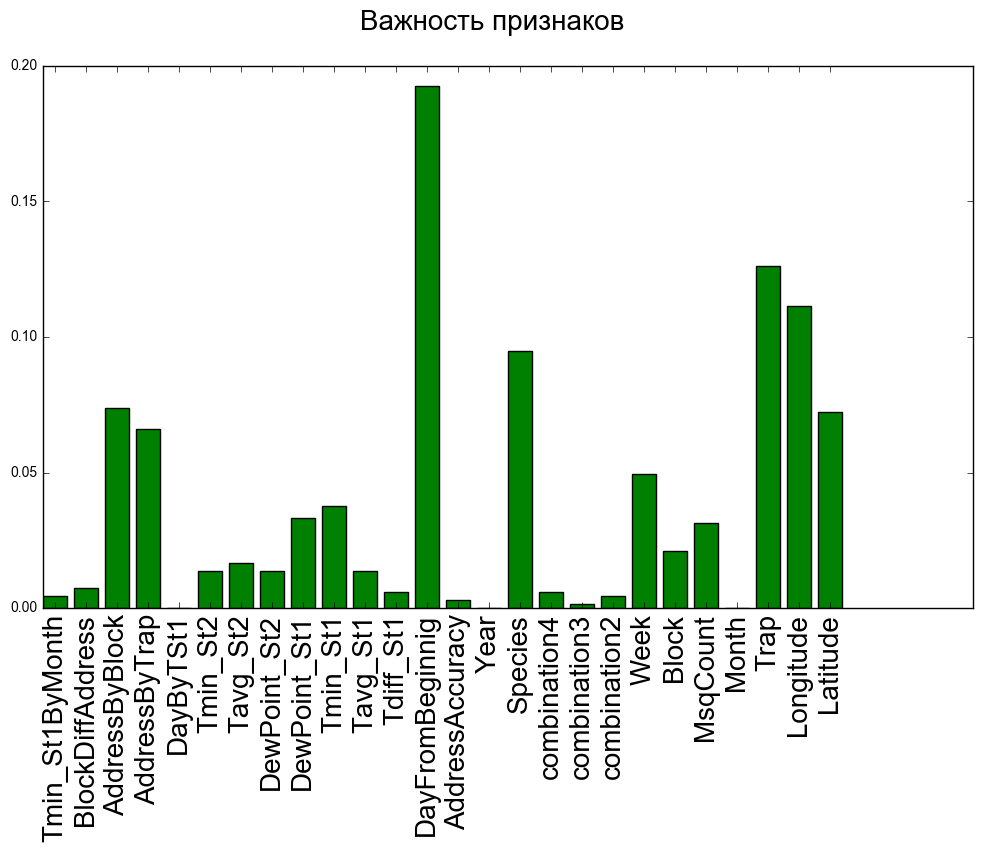

In [81]:
# Crossvalidation
our_cross_validation(trainWeather, trainAnswer, resArr_names)

# Get answer(print accuracy on train) and create csv
get_answer_csv(trainWeather, trainAnswer, testWeather, "submission-4-2611.csv", resArr_names)
print("finished computations")

## 